In [1]:
#lets get our data read
import torch
from torch import nn

#import torch vision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.16.2


# data handling part

In [3]:
train_data=datasets.FashionMNIST(
    root="data",
    train=True,
    transform=ToTensor(),
   # download=True,
    target_transform=None
)

test_data=datasets.FashionMNIST(
    root="data",
    train=False,
    transform=ToTensor() ,  #turns the data from 0-255 into range between 0-1
    #download=True,
    target_transform=None
)

## Explaratory Data Analysis 

In [4]:
print(train_data)
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [5]:
len(train_data),len(test_data)

(60000, 10000)

In [6]:
class_names=train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx=train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
image,label=train_data[0]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
9


In [10]:
class_names[label]

'Ankle boot'

In [11]:
class_to_idx["Ankle boot"]

9

In [12]:
image,label=train_data[1]

* the arrangment are color channel,height and width

In [13]:
image.shape

torch.Size([1, 28, 28])

## lets visualize our data

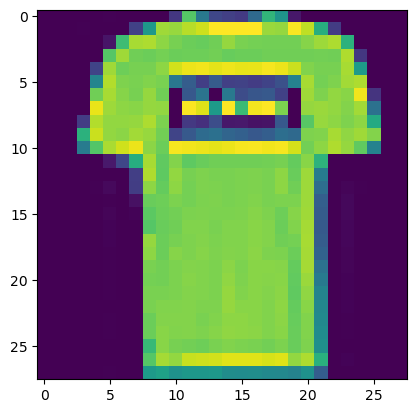

In [14]:
plt.imshow(image.permute(1,2,0));

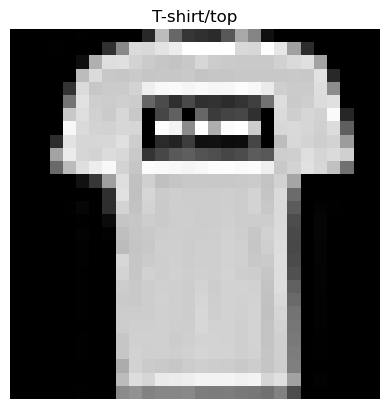

In [15]:
#ploting it in gray scale
plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label]);
plt.axis(False);

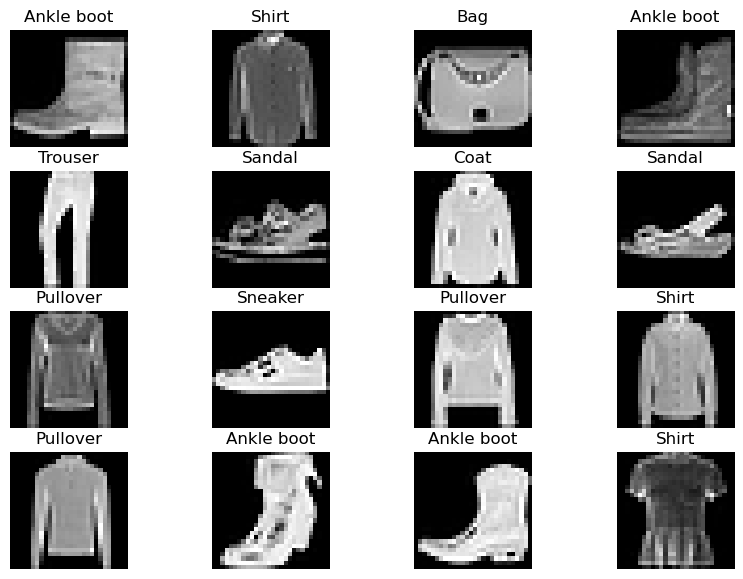

In [16]:
torch.manual_seed(42)
np.random.seed(42)

fig=plt.figure(figsize=(10,7))
row,col=4,4

for i in range(1,row*col+1):
    
    rand_id=torch.randint(0,len(train_data),size=[1]).item()
    image,label=train_data[rand_id]

    fig.add_subplot(row,col,i)
    
    plt.imshow(image.squeeze(),cmap="gray");
    plt.title(class_names[label]);
    plt.axis(False)

In [17]:
# lets handle the dataloader
batch_size=32
from torch.utils.data import DataLoader
train_dataloader=DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)

In [18]:
test_dataloader=DataLoader(
    dataset=test_data,
    shuffle=False,
    batch_size=batch_size
)

In [19]:
len(train_dataloader),len(test_dataloader)

(1875, 313)

In [20]:
1875*32,313*32

(60000, 10016)

In [21]:
#lets check out the data
train_feature_batch,train_label_batch=next(iter( train_dataloader))
train_feature_batch.shape,train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

image shape;  torch.Size([1, 28, 28])
image label;  8


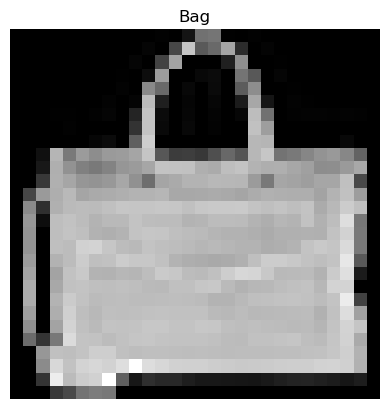

In [22]:
# lets check out our data
rand_idx=torch.randint(0,len(train_feature_batch),size=[1]).item()
images,label=train_feature_batch[rand_idx],train_label_batch[rand_idx]
plt.imshow(images.squeeze(),cmap="gray");
plt.title(class_names[label]);

print("image shape; " ,images.shape)
print("image label; ", label.item())
#plt.write()
plt.axis("off");

In [23]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# lets build a base line model

In [24]:
x=train_feature_batch[0]
x.shape

torch.Size([1, 28, 28])

In [25]:
#lets build it
class FmnistModelV0(nn.Module):
    def __init__(self,
                 input_shape:int,
                 n_neuron:int,
                 output_shape:int
                ):
        super().__init__()
        self.Layer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=n_neuron),
           # nn.ReLU(),
            nn.Linear(in_features=n_neuron,out_features=n_neuron),
           # nn.ReLU(),
            nn.Linear(in_features=n_neuron,out_features=output_shape),
            #nn.softmax()
        )
    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.Layer(x)

In [26]:
#lets initiate our base model
model_v0=FmnistModelV0(
    input_shape=28*28,
    n_neuron=28,
    output_shape=len(class_names)
)
model_v0.to(device)

FmnistModelV0(
  (Layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=28, bias=True)
    (2): Linear(in_features=28, out_features=28, bias=True)
    (3): Linear(in_features=28, out_features=10, bias=True)
  )
)

In [27]:
#lets make an accuracy
import requests 
from pathlib import Path

if Path("helper_function.py").is_file():
    print("file already existice")
else:
    print("downloading file")
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_function.py","wb") as f:
        f.write(request.content)

file already existice


In [28]:
#lets import accuract from the helper function 
from helper_function import accuracy_fn

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_v0.parameters(),lr=0.01)


* since time is one factor that we need to keep an eye on that is 
including accuracy and performace of the model

In [29]:
#a timer displayer
from timeit import default_timer as timer

def print_timer(start:float,
               end:float,
                device:torch.device=None
               ):
    """
   displays  the differenee between start and end time 
    """
    total_time=end-start
    print(f"total time is {total_time:.3f} on the device {device} ")
    return total_time

In [30]:
start_time=timer()
# for i in range(100000):
#     a=90
#     b=10
#     c=a/b
end_time=timer()
print_timer(start_time,end_time,"cpu")

total time is 0.000 on the device cpu 


0.00011049999989154458

* the parameters are updated here once per batch rather than once per epoch
* we are gonna loop through each batch in trainin and testing calculate the loss'es

In [31]:
from tqdm.auto import tqdm
#lets time our modeling time progress
torch.manual_seed(42)
start_timer=timer()

#lets setup the training steps
epochs=3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}---------------> ")
    model_v0.train()
    train_loss=0
    
    for batch,(x,y) in enumerate(train_dataloader):
        y_pred_train=model_v0(x)
        loss=loss_fn(y_pred_train,y)
    
        train_loss+=loss
        #optimizer
        
        optimizer.zero_grad()
        #back prop
        loss.backward()
        #update parameter
        
        optimizer.step()
        if(batch%400==0):
            print(f"number of elements seen {batch*len(x)}/{len(train_dataloader.dataset)} samples")
    
    train_loss/=len(train_dataloader)  #we are dividing it by the number of elements per batch
    
    #inference mode
    model_v0.eval()
    with torch.inference_mode():  
        for x_val,y_val in test_dataloader:
                
            test_loss=0
            test_acc=0
                
            y_val_pred=model_v0(x_val)
                
            test_loss+=loss_fn(y_val_pred,y_val) #loss of the evaluation model   
            test_acc+=accuracy_fn(y_val,y_val_pred.argmax(dim=1))  #argumetns are y_true and y_pred
            
            test_loss/=len(test_dataloader)
            test_acc/=len(test_dataloader)
    print(f"train loss: {train_loss:.3f} | test loss {test_loss:.3f} | accuracy loss {test_acc}")

end_time=timer()
print_timer(start=start_timer,end=end_time,device=str(next(model_v0.parameters()).device))

C:\Users\nebiy\miniconda3\envs\snakey\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch 0---------------> 
number of elements seen 0/60000 samples
number of elements seen 12800/60000 samples
number of elements seen 25600/60000 samples
number of elements seen 38400/60000 samples
number of elements seen 51200/60000 samples


 33%|████████████████████████████                                                        | 1/3 [00:18<00:36, 18.21s/it]

train loss: 0.932 | test loss 0.001 | accuracy loss 0.2795527156549521
Epoch 1---------------> 
number of elements seen 0/60000 samples
number of elements seen 12800/60000 samples
number of elements seen 25600/60000 samples
number of elements seen 38400/60000 samples
number of elements seen 51200/60000 samples


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:36<00:18, 18.05s/it]

train loss: 0.550 | test loss 0.001 | accuracy loss 0.2995207667731629
Epoch 2---------------> 
number of elements seen 0/60000 samples
number of elements seen 12800/60000 samples
number of elements seen 25600/60000 samples
number of elements seen 38400/60000 samples
number of elements seen 51200/60000 samples


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 17.85s/it]

train loss: 0.496 | test loss 0.001 | accuracy loss 0.2995207667731629
total time is 53.566 on the device cpu 


53.566491900000074

# make prediction

In [32]:
#lets modularize
def model_eval(
    model:nn.Module,
    dataset:torch.utils.data.DataLoader,
    loss_fn:nn.Module,
    accuracy_fn
):
    loss,acc=0,0
    model.eval()
    train_loss=0
    with torch.inference_mode():
        for x,y in tqdm(dataset):
            y_pred=model(x)        
            loss+=loss_fn(y_pred,y)
            
            acc+=accuracy_fn(y,y_pred.argmax(dim=1))
    
        #train_loss=loss/len(dataset)
        loss/=len(dataset) 
        acc/=len(dataset)
    return {"model_name":model.__class__.__name__,
           "loss":loss.item(),
            "accuracy_fn":acc}

In [33]:
model_results=model_eval(model=model_v0,
          dataset=test_dataloader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn
          )
model_results

# lets try non lineare model

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 157.13it/s]


{'model_name': 'FmnistModelV0',
 'loss': 0.5021693110466003,
 'accuracy_fn': 82.12859424920129}

In [34]:
class FashionModel_v2(nn.Module):
    def __init__(self,input_feature:int,
                 output_feature:int,
                 n_hidden:int
                ):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_feature,
                     out_features=n_hidden),
            nn.ReLU(),
            nn.Linear(in_features=n_hidden,out_features=output_feature),
            nn.ReLU()
        )
    def forward(self,x):
        return self.layer_stack(x)

In [35]:
model2=FashionModel_v2(
    input_feature=784,
    output_feature=len(class_names),
    n_hidden=10
).to(device)

# lets functionize the training/testing steps

In [36]:
def train_step(
    model:nn.Module,
    data_loader:torch.utils.data.DataLoader,
    loss_fn:nn.Module,
    accuracy_fn,
    optimizer:torch.optim,
    device:torch.device=device
):
    """
    calculate the trainig models loss and caccuracy
    """
    model.train()
    
    train_loss,train_acc=0,0
    
    for batch,(x,y) in enumerate(data_loader):
        #put the data on the same device
        x.to(device)
        y.to(device)
        
        y_pred_train=model(x)

        
        #calculate the loss
        #  loss=loss_fn(y_pred_train,y)
        # acc=accuracy_fn(y,y_pred_train.argmax(dim=1))

        #store accuracy
        train_acc+=accuracy_fn(y,y_pred_train.argmax(dim=1))
        
       
        #calculate loss
        loss=loss_fn(y_pred_train,y)

         #update cumulative loss
        train_loss+=loss
        
        #optimizer
        optimizer.zero_grad()

        #back prop
        loss.backward()
        #update parameter
        
        optimizer.step()
        # if(batch%400==0):
        #     print(f"number of elements seen {batch*len(x)}/{len(train_dataloader.dataset)} samples")
    
    train_loss/=len(data_loader)  #we are dividing it by the number of elements per batch
    train_acc/=len(data_loader)
    print(f"train loss {train_loss:.3f} | train accuracy {train_acc:.3f} ")

* evaluation model

In [37]:
def eval_step(
    model:nn.Module,
    data_loader:torch.utils.data.DataLoader,
    loss_fn:nn.Module,
    accuracy_fn:accuracy_fn,
    device:torch.device=device
):
    """ this performs model evaliation over a test dataset
    """
    test_loss=0
    test_acc=0
     #inference mode
    model.eval()
    with torch.inference_mode():  
        
        for x_val,y_val in data_loader:

            x_val.to(device)
            y_val.to(device) 
                
            y_val_pred=model(x_val)
                
            test_loss+=loss_fn(y_val_pred,y_val) #loss of the evaluation model   
            test_acc+=accuracy_fn(y_val,y_val_pred.argmax(dim=1))  #argumetns are y_true and y_pred
            
        test_loss/=len(test_dataloader)
        test_acc/=len(test_dataloader)
    
        print(f"test losst : {test_loss:.3f} | test accuracy | {test_acc:.3f}")
        

# lets train our data and evaluate it using this functions

In [38]:
#lets train our model

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model2.parameters(),lr=0.01)

In [39]:
#lets start the training
start_time=timer()
epochs=3

for epoch in tqdm(range(epochs)):
    print(f"epoch {epoch} \n ------->")
    train_step(model=model2,
               data_loader=train_dataloader,
               accuracy_fn=accuracy_fn,
               optimizer=optimizer,
               loss_fn=loss_fn,
                device=device
               )
    #lets add test or evaluation method too
    eval_step(model=model2,
             data_loader=test_dataloader,
             accuracy_fn=accuracy_fn,
             loss_fn=loss_fn,
             device=device)

end_timer=timer()
print_timer(start=start_time,
           end=end_timer,
            device=device)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

epoch 0 
 ------->
train loss 1.643 | train accuracy 45.793 


 33%|████████████████████████████                                                        | 1/3 [00:17<00:34, 17.26s/it]

test losst : 1.304 | test accuracy | 60.763
epoch 1 
 ------->
train loss 1.115 | train accuracy 64.513 


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:34<00:17, 17.48s/it]

test losst : 1.043 | test accuracy | 65.166
epoch 2 
 ------->
train loss 0.988 | train accuracy 66.892 


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:52<00:00, 17.39s/it]

test losst : 0.992 | test accuracy | 66.603
total time is 52.185 on the device cpu 


52.18541600000003

In [45]:
def eval_model(
    model:nn.Module,
    data_loader:torch.utils.data.DataLoader,
    loss_fn:nn.Module,
    accuracy_fn:accuracy_fn,
    device:torch.device=device
):
    """ this performs model evaliation over a test dataset,
    and returns dictionary
    """
    test_loss=0
    test_acc=0
     #inference mode
    model.eval()
    with torch.inference_mode():  
        
        for x_val,y_val in data_loader:

            x_val.to(device)
            y_val.to(device) 
                
            y_val_pred=model(x_val)
                
            test_loss+=loss_fn(y_val_pred,y_val) #loss of the evaluation model   
            test_acc+=accuracy_fn(y_val,y_val_pred.argmax(dim=1))  #argumetns are y_true and y_pred
            
        test_loss/=len(test_dataloader)
        test_acc/=len(test_dataloader)
    
    return {
        "model_name":model.__class__.__name__,
        "model_loss":test_loss.item(),
        "model_accuracy":test_acc
    }
        

In [46]:
eval_model(model=model2,
           loss_fn=loss_fn,
           data_loader=test_dataloader,
           accuracy_fn=accuracy_fn,
          )

{'model_name': 'FashionModel_v2',
 'model_loss': 0.9921626448631287,
 'model_accuracy': 66.60343450479233}